# PreTrain

In [1]:
from model.sswae_dev2_2 import SSWAE_HSIC_MNIST as cur_model

import os, sys, configparser, logging, argparse, time
sys.path.append('/'.join(os.getcwd().split('/')[:-2]))

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim

from XAE.dataset import rmMNIST
from XAE.dataset import MNIST
from XAE.util import init_params

import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
y_dim = 8
rm = [1]

d = 64
embed_data = nn.Sequential(
    nn.Conv2d(1, d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, 2*d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Conv2d(2*d, 2*d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Flatten(),
).to(device)

embed_condition = nn.Sequential(
    nn.Linear(49*2*d, d),
    nn.BatchNorm1d(d),
    nn.ReLU(True),
    
    nn.Linear(d, y_dim),
).to(device)

enc_activation = nn.Sequential(
    nn.BatchNorm1d(y_dim),
    nn.ReLU(True),
    nn.Linear(y_dim, 10 - len(rm) + 1),
).to(device)

init_params(embed_data)
init_params(embed_condition)
init_params(enc_activation)

In [3]:
labeled_class = [i for i in range(10) if i not in rm]
print("lab:", labeled_class, "rm:", rm)
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, rm], portion = 1.0, unk=True)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

lab: [0, 2, 3, 4, 5, 6, 7, 8, 9] rm: [1]


In [4]:
def kk(x, y, diag = True):
    stat = 0.
    for scale in [.1, .2, .5, 1., 2., 5., 10.]:
        C = scale*2*y_dim*2
        kernel = (C/(C + (x.unsqueeze(0) - y.unsqueeze(1)).pow(2).sum(dim = 2)))
        if diag:
            stat += kernel.sum()
        else:
            stat += kernel.sum() - kernel.diag().sum()
    return stat

In [6]:
epoch = 20
opt = optim.Adam(list(embed_data.parameters()) + list(embed_condition.parameters()) + list(enc_activation.parameters()), lr = 1e-3, betas = (0.9, 0.999))
crit = nn.CrossEntropyLoss()
running_loss = 0.0

for k in range(epoch):
    for i, (data, condition) in enumerate(train_generator):
        opt.zero_grad()
        n = len(data)
        x = data.to(device)
        y = condition.to(device)
        
        xx = embed_condition(embed_data(x))
        output = enc_activation(xx)
        loss = crit(output, y)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        
    print('[%d] loss: %.3f' % (k + 1, running_loss / len(train_generator)))
    running_loss = 0.0

[1] loss: 0.042
[2] loss: 0.023
[3] loss: 0.017
[4] loss: 0.013
[5] loss: 0.010
[6] loss: 0.008
[7] loss: 0.006
[8] loss: 0.007
[9] loss: 0.007
[10] loss: 0.005
[11] loss: 0.004
[12] loss: 0.004
[13] loss: 0.004
[14] loss: 0.005
[15] loss: 0.003
[16] loss: 0.005
[17] loss: 0.003
[18] loss: 0.004
[19] loss: 0.004
[20] loss: 0.002


In [7]:
batch_size = 100
test_data = MNIST('./data/MNIST', train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

a, b = next(iter(test_generator))
embed_condition(embed_data(a.to(device))).shape

torch.Size([100, 8])

In [8]:
f1 = np.zeros((0, 10))
f2 = np.zeros((0, y_dim))

i = 0
for a, b in test_generator:
    f1x = b.to('cpu').detach().numpy()
    f2x = embed_condition(embed_data(a.to(device))).to('cpu').detach().numpy()
    f1 = np.concatenate((f1, f1x), axis = 0)
    f2 = np.concatenate((f2, f2x), axis = 0)
    i += 1
    if i == 5:
        break
        
digit = np.arange(10)
lab = [digit[l.astype(np.bool_)] for l in f1]
lab = np.concatenate(lab)

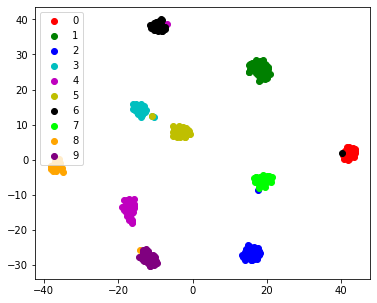

In [9]:
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(f2)

target_ids = list(range(10))

plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(X_2d[lab == i, 0], X_2d[lab == i, 1], c=c, label=str(i))
plt.legend()
plt.show()

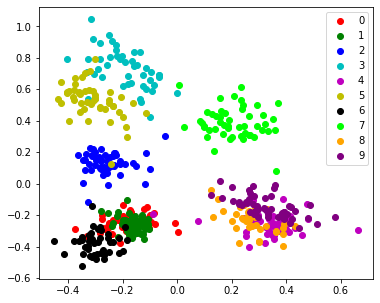

In [10]:
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(f2[lab == i, 0], f2[lab == i, 2], c=c, label=str(i))
plt.legend()
plt.show()

In [11]:
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, rm], portion = 1.0, class_no = True, unk=True)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [12]:
ys = np.zeros((10 - len(rm) + 1, y_dim))
cs = np.zeros(10 - len(rm) + 1)
covs = np.zeros((10 - len(rm) + 1, y_dim, y_dim))

for data, condition in train_generator:
    n = len(data)
    x = data.to(device)
    y = condition.to(device)
    z = embed_condition(embed_data(x))
    labs, idxs, counts = y.unique(dim = 0, return_inverse = True, return_counts = True)
    idxs = labs[idxs].view(n,1).expand(-1, y_dim)
    cc = torch.zeros((10 - len(rm) + 1, y_dim), dtype = torch.float).to(device).scatter_add_(0, idxs, z)
    ys += cc.detach().to('cpu').numpy()
    cs += counts[labs].detach().to('cpu').numpy()
    
    for i in range(10 - len(rm)):
        cov = torch.cov(z[y==i,:].T, correction=0) * torch.sum(y==i)
        covs[i,:,:] += cov.detach().to('cpu').numpy()

In [13]:
w1 = torch.Tensor(ys.transpose()/cs)
w1

tensor([[-0.2067, -0.2609, -0.1927,  0.3601, -0.3162, -0.2775,  0.2220,  0.2781,
          0.3329, -0.1687],
        [-0.2646,  0.2816, -0.1785,  0.6071, -0.0951,  0.5406,  0.2315, -0.1486,
         -0.1694, -0.1373],
        [-0.2243,  0.1312,  0.7234, -0.2607,  0.4807, -0.3657,  0.3545, -0.2352,
         -0.1538, -0.2465],
        [ 0.3272,  0.3088, -0.2707,  0.2091, -0.2134, -0.3985, -0.1130, -0.2489,
         -0.2205, -0.2221],
        [-0.0839, -0.1313, -0.1328,  0.3510,  0.4140, -0.1296,  0.1782, -0.0771,
          0.1174,  0.7542],
        [ 0.6167, -0.0313, -0.1471, -0.1263, -0.1036,  0.5194,  0.5810, -0.1582,
         -0.0375,  0.1091],
        [ 0.2478, -0.2266, -0.2664, -0.1031,  0.5678,  0.2338, -0.2140,  0.4600,
         -0.2307, -0.1576],
        [-0.2239,  0.3043, -0.2177, -0.2329,  0.1915,  0.1556, -0.1709, -0.2568,
          0.3928, -0.2821]])

In [14]:
f1 = nn.Linear(10 - len(rm) + 1, y_dim, bias = False)
f1.weight.data = w1
torch.save(f1.state_dict(), f'./result/mu_{y_dim}_rm_{str(rm).replace(" ","")[1:-1]}_unk.pt')

In [15]:
w2 = torch.tensor((covs.T / (cs - 1)).T)
w2.shape

torch.Size([10, 8, 8])

In [16]:
for i in range(10 - len(rm) + 1):
    e, v = torch.symeig(w2[i,:,:], eigenvectors = True)
    w2[i,:,:] = v @ torch.diag(torch.sqrt(e)) @ v.T

In [17]:
f2 = nn.ConvTranspose2d(10 - len(rm) + 1, 1, y_dim, bias=False)
f2.weight.data = w2.view(10 - len(rm) + 1, 1, y_dim, y_dim)
torch.save(f2.state_dict(), f'./result/cov_{y_dim}_rm_{str(rm).replace(" ","")[1:-1]}_unk.pt')

# Train

In [18]:
from XAE.logging_daily import logging_daily

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

logger = logging_daily('./config/log_info.yaml')
log = logger.get_logging()
log.setLevel(logging.INFO)

cfg = configparser.ConfigParser()
cfg.read('./config/sswae_dev2_rm_1_unk.cfg')

['./config/sswae_dev2_rm_1_unk.cfg']

In [20]:
mm = cur_model(cfg, log, device = device)

mm.gm.mu.load_state_dict(torch.load(f'./result/mu_{mm.y_dim}_rm_{str(rm).replace(" ","")[1:-1]}_unk.pt'))
mm.gm.cov.load_state_dict(torch.load(f'./result/cov_{mm.y_dim}_rm_{str(rm).replace(" ","")[1:-1]}_unk.pt'))

mm.train()
# mm.load('./%s' % (cfg['path_info']['save_path']))

[default |INFO|_base_model.py:27] ------------------------------------------------------------
[default |INFO|_base_model.py:29] model_name : SSWAE_HSIC_MNIST
[default |INFO|_base_model.py:29] train_data : rmMNIST
[default |INFO|_base_model.py:29] train_data_label : True
[default |INFO|_base_model.py:29] z_sampler : gaus
[default |INFO|_base_model.py:29] z_dim : 4
[default |INFO|_base_model.py:29] y_sampler : gaus
[default |INFO|_base_model.py:29] y_dim : 8
[default |INFO|_base_model.py:29] labeled_class : 0,2,3,4,5,6,7,8,9
[default |INFO|_base_model.py:29] unlabeled_class : 1
[default |INFO|_base_model.py:29] test_class : 
[default |INFO|_base_model.py:29] portion : 1.0
[default |INFO|_base_model.py:29] unk : True
[default |INFO|_base_model.py:29] encoder_pretrain : False
[default |INFO|_base_model.py:29] encoder_pretrain_step : 3
[default |INFO|_base_model.py:29] lr : 5e-4
[default |INFO|_base_model.py:29] beta1 : 0.5
[default |INFO|_base_model.py:29] lr_adv : 2e-4
[default |INFO|_ba

[default |INFO|model.py:1823] [01/80]  loss: 2.442897e-01  D: 6.926911e-01  D2: 4.700416e-02  D3: 1.404792e-03
test loss: 1.752741e-01  D: 6.871836e-01  D2: 2.188830e-02  D3: 6.718383e-03


[default |INFO|model.py:1823] [02/80]  loss: 1.605671e-01  D: 6.973531e-01  D2: 1.314168e-02  D3: 7.802943e-03
test loss: 1.846365e-01  D: 6.557832e-01  D2: 7.677050e-03  D3: 1.438435e-02


[default |INFO|model.py:1823] [03/80]  loss: 1.378941e-01  D: 6.941870e-01  D2: 2.760938e-03  D3: 8.974868e-03
test loss: 1.229403e-01  D: 7.224911e-01  D2: -1.705170e-04  D3: 5.465957e-03


[default |INFO|model.py:1823] [04/80]  loss: 1.178348e-01  D: 6.956700e-01  D2: -9.599495e-04  D3: 1.098550e-02
test loss: 1.158593e-01  D: 6.983175e-01  D2: -8.659363e-06  D3: 1.626010e-02


[default |INFO|model.py:1823] [05/80]  loss: 9.526740e-02  D: 6.913820e-01  D2: -2.226542e-03  D3: 1.121054e-02
test loss: 8.637207e-02  D: 6.695099e-01  D2: -2.797565e-03  D3: 1.293506e-02


[default |INFO|model.py:1823] [06/80]  loss: 8.825247e-02  D: 6.940906e-01  D2: -3.182340e-03  D3: 1.452226e-02
test loss: 8.282807e-02  D: 7.005682e-01  D2: -3.595438e-03  D3: 1.516586e-02


[default |INFO|model.py:1823] [07/80]  loss: 8.487867e-02  D: 6.941978e-01  D2: -3.943427e-03  D3: 1.431418e-02
test loss: 8.012216e-02  D: 6.731953e-01  D2: -3.783464e-03  D3: 1.404295e-02


[default |INFO|model.py:1823] [08/80]  loss: 8.017771e-02  D: 6.938490e-01  D2: -4.289451e-03  D3: 1.480779e-02
test loss: 7.812603e-02  D: 6.797169e-01  D2: -3.767986e-03  D3: 1.225600e-02


[default |INFO|model.py:1823] [09/80]  loss: 8.006588e-02  D: 6.961792e-01  D2: -4.198014e-03  D3: 1.466929e-02
test loss: 7.389581e-02  D: 7.075288e-01  D2: -4.861479e-03  D3: 1.503002e-02


[default |INFO|model.py:1823] [10/80]  loss: 7.432401e-02  D: 6.937318e-01  D2: -4.958456e-03  D3: 1.332672e-02
test loss: 7.229874e-02  D: 6.969698e-01  D2: -4.882851e-03  D3: 1.330265e-02


[default |INFO|model.py:1823] [11/80]  loss: 7.074986e-02  D: 6.946276e-01  D2: -4.672000e-03  D3: 1.466496e-02
test loss: 6.945416e-02  D: 7.111485e-01  D2: -4.914694e-03  D3: 1.478778e-02


[default |INFO|model.py:1823] [12/80]  loss: 6.864190e-02  D: 6.935179e-01  D2: -4.860961e-03  D3: 1.492672e-02
test loss: 7.195634e-02  D: 6.786537e-01  D2: -4.501610e-03  D3: 1.513368e-02


[default |INFO|model.py:1823] [13/80]  loss: 6.753553e-02  D: 6.944123e-01  D2: -5.201403e-03  D3: 1.461644e-02
test loss: 6.536234e-02  D: 7.076915e-01  D2: -5.432320e-03  D3: 1.485690e-02


[default |INFO|model.py:1823] [14/80]  loss: 6.690041e-02  D: 6.942626e-01  D2: -5.374562e-03  D3: 1.410048e-02
test loss: 6.720260e-02  D: 7.084582e-01  D2: -5.669327e-03  D3: 1.358952e-02


[default |INFO|model.py:1823] [15/80]  loss: 6.504553e-02  D: 6.938645e-01  D2: -5.574126e-03  D3: 1.450171e-02
test loss: 6.178510e-02  D: 7.106778e-01  D2: -5.035448e-03  D3: 1.562392e-02


[default |INFO|model.py:1823] [16/80]  loss: 6.211972e-02  D: 6.937457e-01  D2: -5.499083e-03  D3: 1.457369e-02
test loss: 6.306867e-02  D: 6.894502e-01  D2: -5.604639e-03  D3: 1.474677e-02


[default |INFO|model.py:1823] [17/80]  loss: 6.115796e-02  D: 6.939686e-01  D2: -6.003888e-03  D3: 1.405623e-02
test loss: 5.972757e-02  D: 6.988353e-01  D2: -5.573053e-03  D3: 1.514032e-02


[default |INFO|model.py:1823] [18/80]  loss: 6.037347e-02  D: 6.943341e-01  D2: -6.102374e-03  D3: 1.425101e-02
test loss: 6.095255e-02  D: 6.993619e-01  D2: -6.393223e-03  D3: 1.373231e-02


[default |INFO|model.py:1823] [19/80]  loss: 6.039384e-02  D: 6.938754e-01  D2: -6.236779e-03  D3: 1.401505e-02
test loss: 5.898725e-02  D: 6.941118e-01  D2: -6.307735e-03  D3: 1.469612e-02


[default |INFO|model.py:1823] [20/80]  loss: 5.887627e-02  D: 6.936080e-01  D2: -6.289538e-03  D3: 1.403352e-02
test loss: 6.107453e-02  D: 7.093450e-01  D2: -6.347742e-03  D3: 1.484519e-02


[default |INFO|model.py:1823] [21/80]  loss: 5.836022e-02  D: 6.935612e-01  D2: -6.437790e-03  D3: 1.423243e-02
test loss: 5.887436e-02  D: 6.966027e-01  D2: -6.811409e-03  D3: 1.273293e-02


[default |INFO|model.py:1823] [22/80]  loss: 5.720019e-02  D: 6.933345e-01  D2: -6.803377e-03  D3: 1.415957e-02
test loss: 5.863015e-02  D: 6.934163e-01  D2: -6.341133e-03  D3: 1.380218e-02


[default |INFO|model.py:1823] [23/80]  loss: 5.715185e-02  D: 6.926896e-01  D2: -6.631406e-03  D3: 1.398913e-02
test loss: 5.678286e-02  D: 6.822878e-01  D2: -6.611061e-03  D3: 1.470875e-02


[default |INFO|model.py:1823] [24/80]  loss: 5.631222e-02  D: 6.932258e-01  D2: -6.934967e-03  D3: 1.411080e-02
test loss: 5.646298e-02  D: 6.916344e-01  D2: -7.151041e-03  D3: 1.416798e-02


[default |INFO|model.py:1823] [25/80]  loss: 5.662623e-02  D: 6.936241e-01  D2: -6.917202e-03  D3: 1.380143e-02
test loss: 5.793145e-02  D: 6.891000e-01  D2: -6.758728e-03  D3: 1.504888e-02


[default |INFO|model.py:1823] [26/80]  loss: 5.747728e-02  D: 6.940484e-01  D2: -7.148919e-03  D3: 1.318263e-02
test loss: 6.071551e-02  D: 7.002141e-01  D2: -7.106495e-03  D3: 1.686828e-02


[default |INFO|model.py:1823] [27/80]  loss: 5.632096e-02  D: 6.934460e-01  D2: -7.322275e-03  D3: 1.356113e-02
test loss: 5.749952e-02  D: 6.933560e-01  D2: -6.963587e-03  D3: 1.377597e-02


[default |INFO|model.py:1823] [28/80]  loss: 5.589585e-02  D: 6.938026e-01  D2: -7.477078e-03  D3: 1.361155e-02
test loss: 5.515350e-02  D: 6.875848e-01  D2: -7.340479e-03  D3: 1.532401e-02


[default |INFO|model.py:1823] [29/80]  loss: 5.570848e-02  D: 6.934733e-01  D2: -7.325727e-03  D3: 1.353693e-02
test loss: 5.432655e-02  D: 6.983268e-01  D2: -7.252998e-03  D3: 1.362097e-02


[default |INFO|model.py:1823] [30/80]  loss: 5.435557e-02  D: 6.935542e-01  D2: -7.410914e-03  D3: 1.369339e-02
test loss: 5.505699e-02  D: 7.097835e-01  D2: -7.535172e-03  D3: 1.407689e-02


[default |INFO|model.py:1823] [31/80]  loss: 5.467300e-02  D: 6.935015e-01  D2: -7.570130e-03  D3: 1.353686e-02
test loss: 5.478509e-02  D: 6.899542e-01  D2: -7.237148e-03  D3: 1.430972e-02


[default |INFO|model.py:1823] [32/80]  loss: 5.374410e-02  D: 6.936993e-01  D2: -7.650094e-03  D3: 1.355228e-02
test loss: 5.464229e-02  D: 6.959498e-01  D2: -7.455482e-03  D3: 1.310861e-02


[default |INFO|model.py:1823] [33/80]  loss: 5.420094e-02  D: 6.939377e-01  D2: -7.856463e-03  D3: 1.344118e-02
test loss: 5.492395e-02  D: 7.026829e-01  D2: -7.079811e-03  D3: 1.393937e-02


[default |INFO|model.py:1823] [34/80]  loss: 5.363217e-02  D: 6.931519e-01  D2: -7.775753e-03  D3: 1.332604e-02
test loss: 5.491494e-02  D: 6.798080e-01  D2: -7.871265e-03  D3: 1.433914e-02


[default |INFO|model.py:1823] [35/80]  loss: 5.408281e-02  D: 6.928081e-01  D2: -7.933122e-03  D3: 1.335236e-02
test loss: 5.416771e-02  D: 6.853132e-01  D2: -8.030376e-03  D3: 1.362789e-02


[default |INFO|model.py:1823] [36/80]  loss: 5.388651e-02  D: 6.941749e-01  D2: -7.983197e-03  D3: 1.304929e-02
test loss: 5.567237e-02  D: 6.933834e-01  D2: -7.774296e-03  D3: 1.349616e-02


[default |INFO|model.py:1823] [37/80]  loss: 5.344586e-02  D: 6.930840e-01  D2: -8.085443e-03  D3: 1.353229e-02
test loss: 5.460669e-02  D: 6.955951e-01  D2: -8.322830e-03  D3: 1.460212e-02


[default |INFO|model.py:1823] [38/80]  loss: 5.327734e-02  D: 6.936751e-01  D2: -8.187402e-03  D3: 1.312146e-02
test loss: 5.336021e-02  D: 6.900771e-01  D2: -7.820206e-03  D3: 1.430468e-02


[default |INFO|model.py:1823] [39/80]  loss: 5.252033e-02  D: 6.933971e-01  D2: -8.245017e-03  D3: 1.333435e-02
test loss: 5.219122e-02  D: 6.965628e-01  D2: -8.044481e-03  D3: 1.383296e-02


[default |INFO|model.py:1823] [40/80]  loss: 5.382094e-02  D: 6.935033e-01  D2: -8.281976e-03  D3: 1.300779e-02
test loss: 5.415206e-02  D: 7.016112e-01  D2: -7.726984e-03  D3: 1.384039e-02


[default |INFO|model.py:1823] [41/80]  loss: 5.240902e-02  D: 6.934606e-01  D2: -8.428853e-03  D3: 1.311072e-02
test loss: 5.303323e-02  D: 6.806255e-01  D2: -8.153591e-03  D3: 1.336926e-02


[default |INFO|model.py:1823] [42/80]  loss: 5.195826e-02  D: 6.931532e-01  D2: -8.552788e-03  D3: 1.322552e-02
test loss: 5.319975e-02  D: 6.908134e-01  D2: -8.926039e-03  D3: 1.319538e-02


[default |INFO|model.py:1823] [43/80]  loss: 5.176174e-02  D: 6.930918e-01  D2: -8.520459e-03  D3: 1.334124e-02
test loss: 5.256462e-02  D: 6.950844e-01  D2: -8.219032e-03  D3: 1.459068e-02


[default |INFO|model.py:1823] [44/80]  loss: 5.190395e-02  D: 6.933736e-01  D2: -8.519740e-03  D3: 1.309250e-02
test loss: 5.494079e-02  D: 6.967165e-01  D2: -8.182735e-03  D3: 1.308323e-02


[default |INFO|model.py:1823] [45/80]  loss: 5.190299e-02  D: 6.930953e-01  D2: -8.608243e-03  D3: 1.307624e-02
test loss: 5.315014e-02  D: 6.973720e-01  D2: -8.276186e-03  D3: 1.354068e-02


[default |INFO|model.py:1823] [46/80]  loss: 5.276024e-02  D: 6.936455e-01  D2: -8.681054e-03  D3: 1.269413e-02
test loss: 5.421692e-02  D: 6.815543e-01  D2: -8.490887e-03  D3: 1.185527e-02


[default |INFO|model.py:1823] [47/80]  loss: 5.160737e-02  D: 6.933366e-01  D2: -8.762830e-03  D3: 1.312188e-02
test loss: 5.361712e-02  D: 6.903148e-01  D2: -8.772116e-03  D3: 1.361412e-02


[default |INFO|model.py:1823] [48/80]  loss: 5.164063e-02  D: 6.932330e-01  D2: -8.682001e-03  D3: 1.300712e-02
test loss: 5.087279e-02  D: 6.991405e-01  D2: -8.820477e-03  D3: 1.380070e-02


[default |INFO|model.py:1823] [49/80]  loss: 5.202488e-02  D: 6.931245e-01  D2: -8.772411e-03  D3: 1.299021e-02
test loss: 5.390201e-02  D: 6.814829e-01  D2: -9.027128e-03  D3: 1.349007e-02


[default |INFO|model.py:1823] [50/80]  loss: 5.136544e-02  D: 6.938864e-01  D2: -8.969982e-03  D3: 1.284555e-02
test loss: 5.302371e-02  D: 6.821376e-01  D2: -8.691931e-03  D3: 1.259508e-02


[default |INFO|model.py:1823] [51/80]  loss: 5.089072e-02  D: 6.925844e-01  D2: -8.981873e-03  D3: 1.299637e-02
test loss: 5.257345e-02  D: 6.961814e-01  D2: -9.100962e-03  D3: 1.190673e-02


[default |INFO|model.py:1823] [52/80]  loss: 5.134658e-02  D: 6.932233e-01  D2: -8.896786e-03  D3: 1.291112e-02
test loss: 5.281843e-02  D: 6.866178e-01  D2: -8.869743e-03  D3: 1.269684e-02


[default |INFO|model.py:1823] [53/80]  loss: 5.158829e-02  D: 6.931735e-01  D2: -9.116750e-03  D3: 1.272679e-02
test loss: 5.429814e-02  D: 6.953226e-01  D2: -9.071379e-03  D3: 1.273487e-02


[default |INFO|model.py:1823] [54/80]  loss: 5.103466e-02  D: 6.931365e-01  D2: -9.075979e-03  D3: 1.276361e-02
test loss: 5.384939e-02  D: 7.040378e-01  D2: -8.942289e-03  D3: 1.269981e-02


[default |INFO|model.py:1823] [55/80]  loss: 5.074850e-02  D: 6.929038e-01  D2: -9.119250e-03  D3: 1.282321e-02
test loss: 5.203494e-02  D: 6.884813e-01  D2: -9.233932e-03  D3: 1.340602e-02


[default |INFO|model.py:1823] [56/80]  loss: 5.019063e-02  D: 6.933681e-01  D2: -9.157519e-03  D3: 1.285019e-02
test loss: 5.302154e-02  D: 6.965333e-01  D2: -9.335661e-03  D3: 1.265009e-02


[default |INFO|model.py:1823] [57/80]  loss: 5.028917e-02  D: 6.930450e-01  D2: -9.226470e-03  D3: 1.281184e-02
test loss: 5.251510e-02  D: 6.898914e-01  D2: -9.080982e-03  D3: 1.412842e-02


[default |INFO|model.py:1823] [58/80]  loss: 5.043303e-02  D: 6.930986e-01  D2: -9.301434e-03  D3: 1.272052e-02
test loss: 5.344495e-02  D: 6.932562e-01  D2: -9.146376e-03  D3: 1.289481e-02


[default |INFO|model.py:1823] [59/80]  loss: 5.034441e-02  D: 6.932055e-01  D2: -9.355224e-03  D3: 1.268161e-02
test loss: 5.214473e-02  D: 6.983583e-01  D2: -9.075861e-03  D3: 1.139396e-02


[default |INFO|model.py:1823] [60/80]  loss: 5.048798e-02  D: 6.933384e-01  D2: -9.463302e-03  D3: 1.242112e-02
test loss: 5.573217e-02  D: 6.971617e-01  D2: -9.675922e-03  D3: 1.063039e-02


[default |INFO|model.py:1823] [61/80]  loss: 5.048497e-02  D: 6.934179e-01  D2: -9.487901e-03  D3: 1.248453e-02
test loss: 5.589514e-02  D: 6.903403e-01  D2: -9.631357e-03  D3: 1.204727e-02


[default |INFO|model.py:1823] [62/80]  loss: 5.181760e-02  D: 6.931102e-01  D2: -9.340647e-03  D3: 1.243891e-02
test loss: 5.565108e-02  D: 6.983955e-01  D2: -9.587650e-03  D3: 1.033318e-02


[default |INFO|model.py:1823] [63/80]  loss: 5.101324e-02  D: 6.930011e-01  D2: -9.429868e-03  D3: 1.261049e-02
test loss: 5.305737e-02  D: 6.788103e-01  D2: -9.586287e-03  D3: 1.180239e-02


[default |INFO|model.py:1823] [64/80]  loss: 4.980318e-02  D: 6.934238e-01  D2: -9.464340e-03  D3: 1.259335e-02
test loss: 5.335257e-02  D: 6.919218e-01  D2: -9.133577e-03  D3: 1.340072e-02


[default |INFO|model.py:1823] [65/80]  loss: 4.968048e-02  D: 6.932863e-01  D2: -9.636326e-03  D3: 1.258314e-02
test loss: 5.115013e-02  D: 6.931213e-01  D2: -9.667883e-03  D3: 1.292347e-02


[default |INFO|model.py:1823] [66/80]  loss: 4.996914e-02  D: 6.931188e-01  D2: -9.643165e-03  D3: 1.257191e-02
test loss: 5.240843e-02  D: 6.808768e-01  D2: -9.545727e-03  D3: 1.306118e-02


[default |INFO|model.py:1823] [67/80]  loss: 4.960580e-02  D: 6.930423e-01  D2: -9.618196e-03  D3: 1.261074e-02
test loss: 5.170052e-02  D: 6.987933e-01  D2: -9.766111e-03  D3: 1.199422e-02


[default |INFO|model.py:1823] [68/80]  loss: 4.961419e-02  D: 6.930431e-01  D2: -9.664842e-03  D3: 1.249043e-02
test loss: 5.148759e-02  D: 6.910300e-01  D2: -9.578142e-03  D3: 1.441904e-02


[default |INFO|model.py:1823] [69/80]  loss: 4.929025e-02  D: 6.935360e-01  D2: -9.691151e-03  D3: 1.257580e-02
test loss: 5.013646e-02  D: 6.925095e-01  D2: -1.003179e-02  D3: 1.343386e-02


[default |INFO|model.py:1823] [70/80]  loss: 4.901944e-02  D: 6.929718e-01  D2: -9.790413e-03  D3: 1.258226e-02
test loss: 5.110312e-02  D: 6.993462e-01  D2: -9.506912e-03  D3: 1.285311e-02


[default |INFO|model.py:1823] [71/80]  loss: 4.929855e-02  D: 6.930000e-01  D2: -9.738081e-03  D3: 1.257061e-02
test loss: 5.105075e-02  D: 6.963413e-01  D2: -1.006916e-02  D3: 1.275552e-02


[default |INFO|model.py:1823] [72/80]  loss: 4.938560e-02  D: 6.930147e-01  D2: -9.740639e-03  D3: 1.261282e-02
test loss: 5.094118e-02  D: 6.845863e-01  D2: -1.008422e-02  D3: 1.191826e-02


[default |INFO|model.py:1823] [73/80]  loss: 4.932270e-02  D: 6.934582e-01  D2: -9.814982e-03  D3: 1.230767e-02
test loss: 5.200757e-02  D: 6.955835e-01  D2: -9.885406e-03  D3: 1.259486e-02


[default |INFO|model.py:1823] [74/80]  loss: 4.946855e-02  D: 6.927713e-01  D2: -9.836254e-03  D3: 1.234051e-02
test loss: 5.149940e-02  D: 6.904828e-01  D2: -9.971027e-03  D3: 1.195225e-02


[default |INFO|model.py:1823] [75/80]  loss: 4.904165e-02  D: 6.934810e-01  D2: -9.880761e-03  D3: 1.234110e-02
test loss: 5.112521e-02  D: 6.944321e-01  D2: -9.958715e-03  D3: 1.270168e-02


[default |INFO|model.py:1823] [76/80]  loss: 4.862061e-02  D: 6.931259e-01  D2: -9.890521e-03  D3: 1.239102e-02
test loss: 5.116377e-02  D: 6.886040e-01  D2: -1.006093e-02  D3: 1.356932e-02


[default |INFO|model.py:1823] [77/80]  loss: 4.855813e-02  D: 6.934253e-01  D2: -1.000213e-02  D3: 1.239642e-02
test loss: 5.118576e-02  D: 6.848162e-01  D2: -9.880610e-03  D3: 1.290100e-02


[default |INFO|model.py:1823] [78/80]  loss: 4.899703e-02  D: 6.931290e-01  D2: -9.981898e-03  D3: 1.226465e-02
test loss: 5.126384e-02  D: 6.923626e-01  D2: -9.601555e-03  D3: 1.144121e-02


[default |INFO|model.py:1823] [79/80]  loss: 4.898493e-02  D: 6.935617e-01  D2: -9.997384e-03  D3: 1.230472e-02
test loss: 5.071876e-02  D: 6.968905e-01  D2: -1.001534e-02  D3: 1.222425e-02


[default |INFO|model.py:1823] [80/80]  loss: 4.834705e-02  D: 6.930279e-01  D2: -9.951975e-03  D3: 1.234141e-02
test loss: 5.111644e-02  D: 6.937507e-01  D2: -1.019691e-02  D3: 1.204153e-02


[default |INFO|model.py:1938] Training Finished!
[default |INFO|model.py:1939] Elapsed time: 3021.788s


# Test

In [21]:
batch_size = 100
test_data = MNIST(cfg['path_info']['data_home'], train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

In [22]:
test_iter = iter(test_generator)
true_label = np.zeros(n*batch_size)
lab_t = torch.Tensor(range(10))
for i in range(n):
    img, lab = next(test_iter)
    true_label[(i*batch_size):((i+1)*batch_size)] = (lab_t*lab).sum(dim=1).detach().numpy()


In [31]:
target = []
n = len(true_label)
for i in range(10):
    target_d = np.arange(n)[true_label == i]
    target.append(target_d[-i])
target
x = torch.Tensor(np.concatenate([np.array(test_data[i][0]) for i in target])).unsqueeze(1).to(device)
z = mm.encode(x)
recon = mm.decode(z).squeeze(1).detach().to('cpu').numpy()

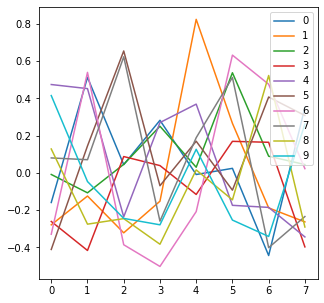

In [32]:
fig, ax = plt.subplots(figsize = (5.0, 5.0))
for i in range(10):
    ax.plot(z[i, 0:mm.y_dim].detach().to('cpu').numpy(), label = "%s" % i)
plt.legend()
plt.show()

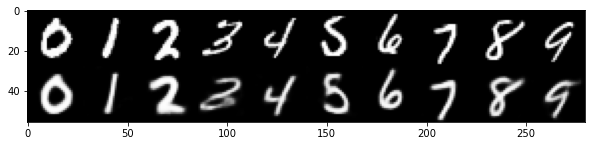

In [33]:
sample_data = []

sample_data.append(np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1))
sample_data.append(np.concatenate([recon[i,:,:] for i in range(10)], axis = 1))
sample_data = np.concatenate(sample_data, axis = 0)
fig = plt.figure(figsize=(10.0,10.0))
plt.imshow(sample_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.show()

# Sample Generation

## 1. Exemplar Generation

In [34]:
from XAE.sampler import gaus

exn = 5

In [35]:
zz = torch.cat((torch.zeros(1,mm.z_dim), gaus(exn,mm.z_dim)), dim = 0).to(device)
new_z = torch.cat((z[:,0:mm.y_dim].repeat_interleave(exn + 1, dim = 0).to(device), zz.repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

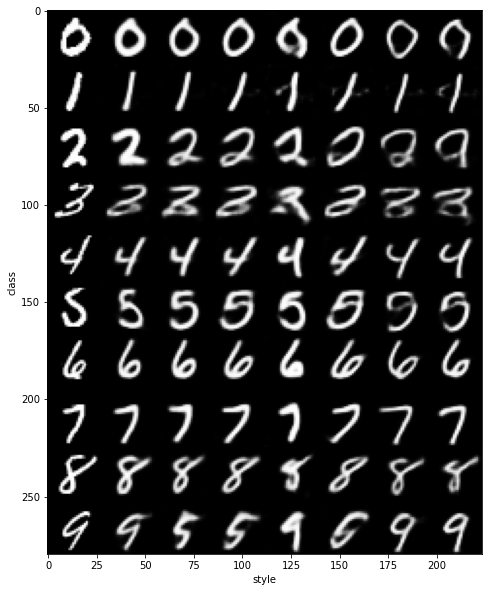

In [36]:
img_data = []
for i in range(10):
    img_data.append(np.concatenate([test_data[target[i]][0].numpy()[0,:,:]] + [recon[i,:,:]] + [new_x[(exn+1)*i + j] for j in range(exn+1)], axis = 1))
img_data = np.concatenate(img_data, axis = 0)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()

## 2. Style Transfer

In [37]:
new_z = torch.cat((z[:,:mm.y_dim].repeat_interleave(10, dim = 0), z[:,mm.y_dim:].repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

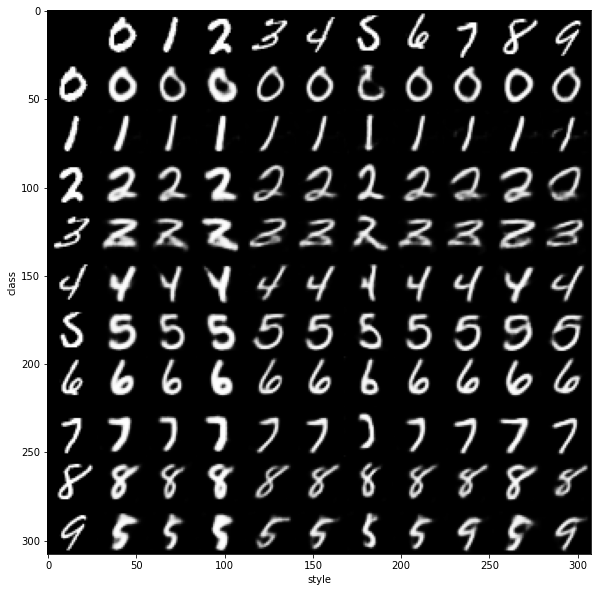

In [38]:
img_data = np.ones((28*11, 28*11))*-1
img_data[:28,28:] = np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1)
for i in range(10):
    img_data[((i+1)*28):((i+2)*28),:28] = test_data[target[i]][0].numpy()[0,:,:]
    img_data[((i+1)*28):((i+2)*28),28:] = np.concatenate(new_x[(10*i):(10*(i+1)),:,:], axis = 1)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()